In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam

import matplotlib.pyplot as plt
import random
from tqdm import trange

from general_utils import AttrDict
from reward_induced.models.reward_predictor_model import RewardPredictorModel, R_CLASSES_BASE
from reward_induced.utils import *
from sprites_datagen.moving_sprites import MovingSpriteDataset
from sprites_datagen.rewards import *


/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=4,      # number of shapes per trajectory
        rewards=[AgentXReward, AgentYReward, TargetXReward, TargetYReward],
    )

In [4]:
dataset = MovingSpriteDataset(spec)
dataset[0]['rewards']

{'agent_x': array([0.5440347 , 0.5438708 , 0.5437069 , 0.5435429 , 0.543379  ,
        0.5432151 , 0.5430511 , 0.5428872 , 0.5427233 , 0.5425593 ,
        0.5423954 , 0.5422315 , 0.5420675 , 0.5419036 , 0.5417397 ,
        0.54157573, 0.5414118 , 0.5412479 , 0.54108393, 0.54092   ,
        0.5407561 , 0.54059213, 0.5404282 , 0.5402643 , 0.54010034,
        0.5399364 , 0.5397725 , 0.53960854, 0.5394446 , 0.5392807 ],
       dtype=float32),
 'agent_y': array([0.669895  , 0.6692992 , 0.6687034 , 0.66810757, 0.66751176,
        0.66691595, 0.66632015, 0.66572434, 0.6651285 , 0.6645327 ,
        0.6639369 , 0.6633411 , 0.66274524, 0.6621494 , 0.6615536 ,
        0.6609578 , 0.660362  , 0.6597662 , 0.6591704 , 0.6585746 ,
        0.6579788 , 0.65738297, 0.65678716, 0.65619135, 0.65559554,
        0.6549997 , 0.65440387, 0.65380806, 0.65321225, 0.65261644],
       dtype=float32),
 'target_x': array([0.10951082, 0.11663064, 0.12375046, 0.13087028, 0.13799012,
        0.14510994, 0.15222976, 0.

# Train reward-induced representations with **RPM image encoder**

In [5]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 20  # number of conditioning frames
T_future = 10  # number of future frames to predict rewards for
batch_size = 32

lr = 1e-3
n_iter = 10_000
log_interval = 1_000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# # DEBUG - check computation graph of the model
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# from torchviz import make_dot

# model = RewardPredictorModel(image_shape, n_frames, T_future).to(device)
# image = dataset[0]['images']
# image = torch.tensor(image).to(device)
# pred_rewards = model(image[:n_frames].unsqueeze(0),
#                      image[n_frames:].unsqueeze(0))['agent_x']

# make_dot(pred_rewards, params=dict(model.named_parameters())).render('RPM_comp_graph', format='png')
# make_dot(pred_rewards, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render('RPM_comp_graph_back_prop', format='png')

In [7]:
def train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True):
	losses = []
	model.to(device)
	print(f'[INFO] Training complete reward predictor model on device: {device} ...')

	for itr in trange(n_iter):
		images, rewards = generate_batch(dataset, batch_size, itr)

		reward_type_list = random.sample(R_CLASSES_BASE, k=3) if not is_complete else R_CLASSES_BASE
		# assume n_frames + T_future == len(images)
		pred_rewards = model(  # add batch dimension for images
			conditioning_frames=images[:, :n_frames].to(device), 
			future_frames=images[:, n_frames:].to(device),
			reward_type=reward_type_list
		)

		loss = 0
		for reward_type, pred_reward in pred_rewards.items():
			reward = torch.tensor(rewards[reward_type][:, n_frames:], 
						 dtype=torch.float32, device=device)
			loss += loss_fn(pred_reward, reward)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

	return losses

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

### (a) Train with complete reward annotation

In [9]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [10]:
losses_complete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1000/10000 [06:31<58:50,  2.55it/s] 

[1000 / 10000] RPM loss: 0.02856401726603508


 20%|██        | 2000/10000 [13:35<56:28,  2.36it/s]  

[2000 / 10000] RPM loss: 0.007283840794116259


 30%|███       | 3000/10000 [20:51<49:11,  2.37it/s]  

[3000 / 10000] RPM loss: 0.004417555406689644


 40%|████      | 4000/10000 [28:08<45:44,  2.19it/s]  

[4000 / 10000] RPM loss: 0.003679901361465454


 50%|█████     | 5000/10000 [35:25<34:54,  2.39it/s]

[5000 / 10000] RPM loss: 0.002146413316950202


 60%|██████    | 6000/10000 [42:34<27:21,  2.44it/s]

[6000 / 10000] RPM loss: 0.00187674758490175


 70%|███████   | 7000/10000 [49:45<20:51,  2.40it/s]

[7000 / 10000] RPM loss: 0.0010473469737917185


 80%|████████  | 8000/10000 [57:10<16:40,  2.00it/s]

[8000 / 10000] RPM loss: 0.001167474314570427


 90%|█████████ | 9000/10000 [1:04:34<06:10,  2.70it/s]

[9000 / 10000] RPM loss: 0.0008347703842446208


100%|██████████| 10000/10000 [1:10:43<00:00,  2.36it/s]

[10000 / 10000] RPM loss: 0.0008888293523341417


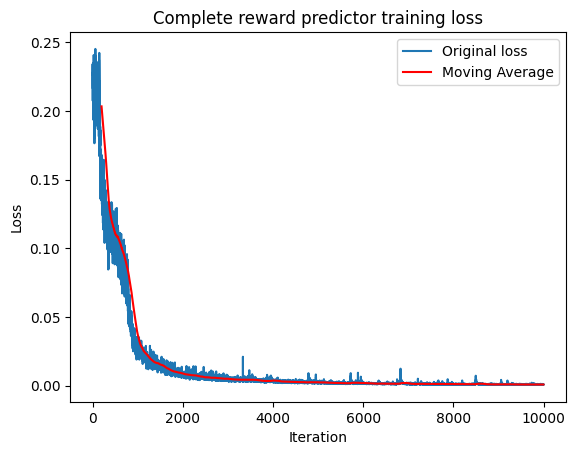

In [11]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Complete reward predictor training loss')
plt.legend()
plt.show()

In [12]:
PATH = 'complete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [13]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>

### (b) Train with incomplete reward annotation

In [14]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [15]:
losses_incomplete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=False)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1000/10000 [05:26<1:00:28,  2.48it/s]

[1000 / 10000] RPM loss: 0.0429820641875267


 20%|██        | 2000/10000 [10:37<39:28,  3.38it/s]  

[2000 / 10000] RPM loss: 0.013319149613380432


 30%|███       | 3000/10000 [15:26<35:07,  3.32it/s]

[3000 / 10000] RPM loss: 0.0034285900183022022


 40%|████      | 4000/10000 [20:25<28:28,  3.51it/s]

[4000 / 10000] RPM loss: 0.0015947502106428146


 50%|█████     | 5000/10000 [25:32<29:44,  2.80it/s]

[5000 / 10000] RPM loss: 0.0012238301569595933


 60%|██████    | 6000/10000 [30:21<20:28,  3.25it/s]

[6000 / 10000] RPM loss: 0.0008957968093454838


 70%|███████   | 7000/10000 [34:51<14:55,  3.35it/s]

[7000 / 10000] RPM loss: 0.001199838356114924


 80%|████████  | 8000/10000 [39:13<09:17,  3.59it/s]

[8000 / 10000] RPM loss: 0.0011062616249546409


 90%|█████████ | 9000/10000 [44:13<04:26,  3.76it/s]

[9000 / 10000] RPM loss: 0.001035822439007461


100%|██████████| 10000/10000 [48:52<00:00,  3.41it/s]

[10000 / 10000] RPM loss: 0.0007250486523844302


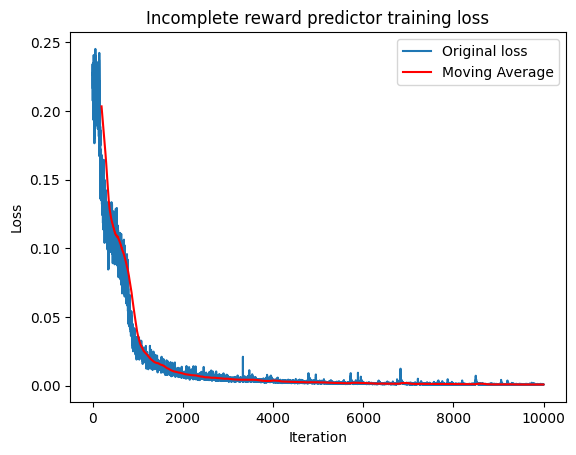

In [16]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Incomplete reward predictor training loss')
plt.legend()
plt.show()

In [17]:
PATH = 'incomplete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [18]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>